# Table of Contents

1. [Setup](#Setup)
2. [Isolate ML Features](#Isolate-ML-Features)
3. [PCA Analysis](#PCA-Analysis)
4. [Machine Learning Algorithms](#Machine-Learning-Algorithms)
    1. [Train-Test Split](#Train-Test-Split)
    2. [Sci-kit Learn Models](#Sci-kit-Learn-Models)
    3. [Deep Learning](#Deep-Learning)
    4. [Ensemble Model](#Ensemble Model)
5. [Cross Validation](#Cross-Validation)
6. [Figures](#Figures)
    1. [ROC Curve](#ROC-Curve)
    2. [Feature Importance](#Feature-Importance)

# Setup
[Back to Top](#Table-of-Contents)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys, subprocess
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

# FEATURE_DIR - directory where feature dataframes are saved
DATA_DIR = ROOT_DIR + 'dataframes/'

FIGURE_DIR = ROOT_DIR + 'figures/'

In [3]:
DF_prest = pd.concat([pd.read_csv(DATA_DIR+'DF_prest_features_1.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_2.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_3.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_4.csv',index_col=0)])
print 'Number of peptides:', len(DF_prest)

Number of peptides: 45206


Mark all peptides above the mean expression value as "Expressed", and all peptides below as "Not Expressed"

In [4]:
target = 'expressed'
DF_prest.loc[:,target] = DF_prest.conc_cf > DF_prest.conc_cf.mean()

Remove all peptides between the 25th and 75th percentile of expression

In [5]:
min_expressed = np.percentile(DF_prest['conc_cf'],75)
max_not_expressed = np.percentile(DF_prest['conc_cf'],25)

DF_prest_filtered = DF_prest[(DF_prest['conc_cf'] > min_expressed) | (DF_prest['conc_cf'] < max_not_expressed)]

print 'Number expressed:',len(DF_prest_filtered[DF_prest_filtered[target]])
print 'Number not expressed:',len(DF_prest_filtered[DF_prest_filtered[target]==False])
print 'Min expression cutoff:',min_expressed
print 'Max non-expression:',max_not_expressed

Number expressed: 11301
Number not expressed: 11302
Min expression cutoff: 7.2576
Max non-expression: 3.269225


## Isolate ML Features
[Back to Top](#Table-of-Contents)

In [6]:
aa_features = ['list_comp_A','list_comp_R','list_comp_N',
               'list_comp_D','list_comp_C','list_comp_Q','list_comp_E','list_comp_G',
               'list_comp_H','list_comp_I','list_comp_L','list_comp_K','list_comp_M',
               'list_comp_F','list_comp_P','list_comp_S','list_comp_T','list_comp_W',
               'list_comp_Y','list_comp_V',
               # Amino acid types
               'frac_aliphatic', 'frac_uncharged_polar', 'frac_polar',
               'frac_hydrophobic', 'frac_positive', 'frac_sulfur', 'frac_negative', 'frac_amide',
               'frac_alcohol']

disorder_features = ['disembl_COILS_frac','disembl_REM465_frac','disembl_HOTLOOPS_frac','ronn_avg','ronn_frac',
                    'disopred_avg','disopred_pb_avg','disopred_frac','disopred_pb_frac']

                    
phys_features = ['aa_len',                                        
                # Physical properties
                 'bio_pI','bio_mW','bio_aromaticity','bio_instability','bio_gravy','abs_avg_charge','abs_charge',
                 'avg_charge']
                    
rna_features = ['AAA','AAC','AAT','AAG','ACA','ACC','ACT','ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT',
                'AGG','CAA','CAC','CAT','CAG','CCA','CCC','CCT','CCG','CTA','CTC','CTT','CTG','CGA','CGC',
                'CGT','CGG','TAA','TAC','TAT','TAG','TCA','TCC','TCT','TCG','TTA','TTC','TTT','TTG','TGA',
                'TGC','TGT','TGG','GAA','GAC','GAT','GAG','GCA','GCC','GCT','GCG','GTA','GTC','GTT','GTG',
                'GGA','GGC','GGT','GGG',
                'GC_content','list_nuc_A','list_nuc_C','list_nuc_G','list_nuc_T',
                'GC30',
                # SD sequences
                'sd_like_fwd','sd_like_fwd_frac','sd_like_rev','sd_like_rev_frac','sd_seq_fwd',
                'sd_seq_fwd_frac','sd_seq_rev','sd_seq_rev_frac',
                # RNA folding
                'RNA_folding_energy','RNA_40_energy','tAI']
                    
ss_features = ['acc20_mean','ss_helix', 'ss_ext', 'ss_c', 'ss8_helix', 'ss8_ext', 'ss8_turn', 'ss8_helix3',
               'ss8_pi_helix', 'ss8_bridge', 'ss8_bend', 'ss8_coil', 'acc_frac',
               'in_gravy','out_gravy', 'acc_hydrophilic_in','acc_hydrophilic_out',
               'acc_hydrophobic_in','acc_hydrophobic_out']

list_of_features = aa_features+disorder_features+phys_features+rna_features+ss_features

DF_prest_features = DF_prest_filtered[list_of_features]

In [7]:
len(list_of_features)

147

In [8]:
X = DF_prest_features.values
y = DF_prest_filtered[target].values
n_samples, n_features = X.shape
print("No. of samples = %d" % n_samples)
print("No. of features = %d" % n_features)

DF_prest_filtered.to_csv(DATA_DIR+'DF_prest_filtered.csv')

No. of samples = 22603
No. of features = 147


# PCA Analysis
[Back to Top](#Table-of-Contents)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

print X_pca.shape
print pca.explained_variance_ratio_[:2]

(22603, 147)
[ 0.11839395  0.09777768]


/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


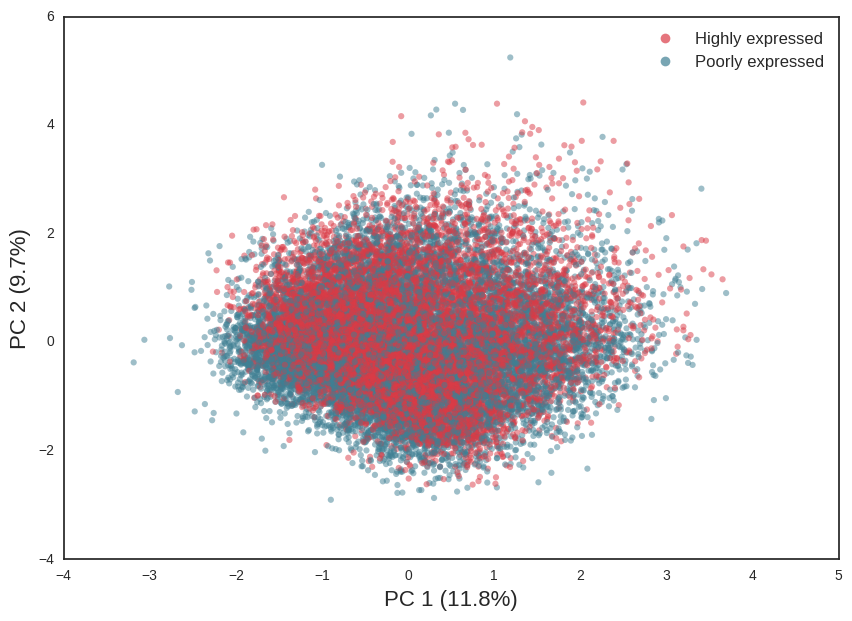

In [10]:
sns.set_style('white')

fig,ax = plt.subplots(figsize=(10,7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=cmap)

point1 = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=sns.diverging_palette(220, 10)[-1],alpha=0.7)
point2 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor=sns.diverging_palette(220, 10)[0],alpha=0.7)

ax.legend((point1,point2),('Highly expressed','Poorly expressed'),fontsize=12)
ax.set_xlabel('PC 1 (11.8%)',fontsize=16)
ax.set_ylabel('PC 2 (9.7%)',fontsize=16)

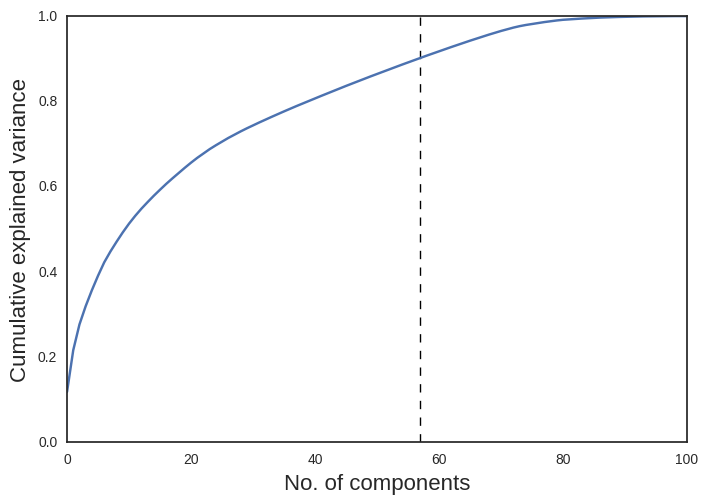

In [11]:
sns.set_style('white')
fig,ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
min_comp = min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0])
ax.vlines(min_comp,0,1,linestyles='dashed',linewidth=1)
ax.set_ylim((0,1))
ax.set_xlim((0,100))

ax.set_xlabel('No. of components',fontsize=16)
ax.set_ylabel('Cumulative explained variance',fontsize=16);

# Machine Learning Algorithms
[Back to Top](#Table-of-Contents)

1. [Train-Test Split](#Train-Test-Split)
2. [Sci-kit Learn Models](#Sci-kit-Learn-Models)
    1. [Fit Hyperparameters](#Fit-Hyperparameters)
3. [Deep Learning](#Deep-Learning)
    1. [TensorFlow Setup](#TensorFlow-Setup)
    2. [Optimize Parameters](#Optimize-Parameters)
    3. [Train Final Model](#Train-Final-Model)
4. [Ensemble Model](#Ensemble-Model)

### Train-Test Split
[Back to Top](#Machine-Learning-Algorithms)

The data will be split into a 70 - 30 split between training and testing sets. After the split, the training data will be scaled to have a mean of 0 and variance 1. This same scaling factor will be applied to the other sets. This ensures that the testing and validation data do not introduce bias in the pre-processing steps.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)


print "Train data shape: %r, Train target shape: %r" % (X_train.shape, y_train.shape)
print "Test data shape: %r, Test target shape: %r" % (X_test.shape, y_test.shape)

print "Train-Test Ratio: %.2f-%.2f" % (np.true_divide(X_train.shape[0],X.shape[0]),
                                                np.true_divide(X_test.shape[0],X.shape[0]))


Train data shape: (15822, 147), Train target shape: (15822,)
Test data shape: (6781, 147), Test target shape: (6781,)
Train-Test Ratio: 0.70-0.30


In [13]:
print "Train - Test data with expressed label:", (y_train==1).sum(),'-',(y_test==1).sum()
print "Train - Test data with not expressed label:", (y_train==0).sum(),'-',(y_test==0).sum()

Train - Test data with expressed label: 7913 - 3388
Train - Test data with not expressed label: 7909 - 3393


### Sci-kit Learn Models
[Back to Top](#Machine-Learning-Algorithms)

In [14]:
clf_names = ['Logistic Regression','Support Vector Classifier',
             'Random Forest Classifier','Deep Neural Network','Ensemble Model']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

### Logistic Regression
clf1 = LogisticRegression()

### Linear SVM Classifier
clf2 = LinearSVC(dual=False,penalty='l1',random_state=0)

### Random Forest Classifier
clf3 = RandomForestClassifier(n_estimators=200,oob_score=True,random_state=0,n_jobs=-1)

clfs = [clf1,clf2,clf3]

In [16]:
from sklearn.model_selection import GridSearchCV

params1 = {'C':[.1,.5,.75,.9,1]
        }

params2 = {'C':[.01,.03,.1,.5,.75,.9,1,3]
        }

params3 = {'n_estimators': [200,500,1000],
           'max_depth': [6,10,15,20,None],
           'min_samples_leaf': [1,2,5],
           'min_samples_split': [2,5]
        }

params = [params1,params2,params3]

#### Fit Hyperparameters
[Back to Top](#Machine-Learning-Algorithms)

In [17]:
def runPipeline(clf,params,train=(X_train,y_train),test=(X_test,y_test)):
    clf.fit(train[0],train[1])
    print 'Initial Training Accuracy:',clf.score(train[0],train[1])
    print 'Initial Testing Accuracy:',clf.score(test[0],test[1])
    
    n_subsamples = 1000
    X_small_train, y_small_train = train[0][:n_subsamples], train[1][:n_subsamples]
    
    gs = GridSearchCV(clf,
                      params,
                      cv=3,
                      verbose=1,
                      scoring = 'roc_auc',
                      error_score=0,
                      n_jobs = -1)
    
    _ = gs.fit(X_small_train, y_small_train)
    clf.set_params(**gs.best_params_)
    clf.fit(train[0], train[1])
    
    print 'Final Training Accuracy:',clf.score(train[0],train[1])
    print 'Final Testing Accuracy:',clf.score(test[0],test[1])
    
    return clf

In [18]:
for i in range(len(clfs)):
    clfs[i] = runPipeline(clfs[i],params[i])

Initial Training Accuracy: 0.682720262925
Initial Testing Accuracy: 0.668780415868
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


Final Training Accuracy: 0.681329793958
Final Testing Accuracy: 0.666715823625
Initial Training Accuracy: 0.681709012767
Initial Testing Accuracy: 0.669222828491
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.2s finished


Final Training Accuracy: 0.681772215902
Final Testing Accuracy: 0.667895590621
Initial Training Accuracy: 1.0
Initial Testing Accuracy: 0.682200265448
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.8min finished


Final Training Accuracy: 0.988876248262
Final Testing Accuracy: 0.679545789707


In [19]:
clfs

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LinearSVC(C=0.03, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
      verbose=0),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=15, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_jobs=-1, oob_score=True, random_state=0,
             verbose=0, warm_start=False)]

### Deep Learning
[Back to Top](#Machine-Learning-Algorithms)

#### TensorFlow Setup
[Back to Top](#Machine-Learning-Algorithms)

We use Google's TensorFlow implementation of neural networks to apply deep learning

In [20]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
TF_DIR = ROOT_DIR+'misc_files/tf_models/'

In [21]:
train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_train.astype(np.float32),target=y_train.astype(np.float32))
test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_test.astype(np.float32),target=y_test.astype(np.float32))

In [22]:
# Specify important validation metrics
validation_metrics = {'accuracy': tf.contrib.metrics.streaming_accuracy,
                      'precision': tf.contrib.metrics.streaming_precision,
                      'recall': tf.contrib.metrics.streaming_recall}

# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=147)]

In [23]:
monitor_params = {'x':test_set.data,
                 'y':test_set.target,
                 'every_n_steps':50,
                 'metrics':validation_metrics,
                 'early_stopping_metric':'loss',
                 'early_stopping_metric_minimize':True,
                 'early_stopping_rounds':200}

clf_params = {'feature_columns':feature_columns,
              'hidden_units':[100,200,100],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1)}

fit_params = {'x':train_set.data,
              'y':train_set.target,
              'steps':10000}

#### Optimize Parameters
[Back to Top](#Machine-Learning-Algorithms)

Since neural networks take much longer to train than other algorithms, we sweep through each parameter separately.
**NOTE:
Make sure that each model directory is empty before running TensorFlow, or it will continue training old models rather than training a new model**

In [24]:
def paramSweep(param,vals,start=0,monitor_params=dict(monitor_params),clf_params=dict(clf_params),
               fit_params=dict(fit_params)):
    
    # Initialize Variables
    n_clfs = len(vals)
    clfs = [None]*n_clfs
    monitors = [None]*n_clfs
    
    print('Sweeping through %d values for "%s"'%(n_clfs,param))
    
    for i in range(n_clfs):
       
        # Initialize model directory
        model_dir = os.path.join(TF_DIR,param,str(i+start))
        
        print('"%s" = %s'%(param,str(vals[i])))
        print('Model saved in "%s"'%model_dir)
        
        # Initialize monitor
        monitors[i] = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)
        
        # Update parameters
        clf_params[param] = vals[i]
        clf_params['model_dir'] = model_dir
        fit_params['monitors'] = [monitors[i]]

        # Initialize classifier
        clfs[i] = tf.contrib.learn.DNNClassifier(**clf_params)
        
        # Train classifier
        clfs[i].fit(**fit_params)
        
        # Test classifier
        scores = clfs[i].evaluate(x=test_set.data, y=test_set.target)
        print('Accuracy: {0:f}'.format(scores['accuracy']))
        print('AUC: {0:f}'.format(scores['auc']))

    return clfs

In [25]:
# opt_clfs = paramSweep('optimizer',[tf.train.AdagradOptimizer(learning_rate=0.05),
#                                    tf.train.RMSPropOptimizer(learning_rate=0.0001),
#                                    tf.train.RMSPropOptimizer(learning_rate=0.0005),
#                                    tf.train.RMSPropOptimizer(learning_rate=0.0001,decay=0.5),
#                                    tf.train.AdamOptimizer(learning_rate=0.0001)])

In [26]:
# hidden_unit_clfs = paramSweep('hidden_units',[[100],[500],[100,200,100],[500,500,500]])

In [27]:
# dropout_clfs = paramSweep('dropout',[0.25,0.5,0.75])

#### Train Final Model
[Back to Top](#Machine-Learning-Algorithms)

Best parameters:
* Optimizer - RMSProp/Adam
* Hidden Units - [100,200,100]
* Dropout: 0.5

In [28]:
# Initialize model directory
model_dir = TF_DIR+'final/'

# Remove files from model directory
# subsystem.call(['rm -r',model_dir])

# Initialize monitor
monitor = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)

# Update parameters
clf_params = {'feature_columns':feature_columns,
              'hidden_units':[100,200,100],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
              'model_dir': model_dir}

fit_params = {'steps':10000,
              'monitors': [monitor]}

# Initialize classifier
final_nn = tf.contrib.learn.DNNClassifier(**clf_params)

# Train classifier
# final_nn.fit(x=train_set.data,y=train_set.target,**fit_params)

# Test classifier
scores = final_nn.evaluate(x=test_set.data, y=test_set.target)
print('Accuracy: {0:f}'.format(scores['accuracy']))
print('AUC: {0:f}'.format(scores['auc']))

Accuracy: 0.675859
AUC: 0.753587


In [29]:
clfs.append(final_nn)

## Ensemble Model
[Back to Top](#Machine-Learning-Algorithms)

Since Random Forest and Deep Neural Networks performed best, we will create an ensemble model between the two by averaging their prediction probabilities. Ensemble classifiers tend to outperform individual classifiers as each classifier may learn different patterns in the data.

In [30]:
test_probs = np.zeros((5,len(y_test)))
test_preds = np.zeros((5,len(y_test)))

for i,clf in enumerate(clfs):
    if type(clf) == LinearSVC:
        test_probs[i] = clf.decision_function(X_test)
    else:
        test_probs[i] = clf.predict_proba(X_test)[:,1]
        
    test_preds[i] = clf.predict(X_test)
    
# Ensemble model created from Random Forest and NN
test_probs[4] = test_probs[[2,3]].mean(axis=0)
test_preds[4] = test_probs[4] > 0.5

In [31]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

In [32]:
print 'TEST SET ACCURACY:\n'
for i in range(test_probs.shape[0]):
    print clf_names[i],'Accuracy:',round(accuracy_score(y_test,test_preds[i]),3)

TEST SET ACCURACY:

Logistic Regression Accuracy: 0.667
Support Vector Classifier Accuracy: 0.668
Random Forest Classifier Accuracy: 0.68
Deep Neural Network Accuracy: 0.676
Ensemble Model Accuracy: 0.689


In [33]:
print 'TEST SET AUC:\n'
for i in range(test_probs.shape[0]):
    print clf_names[i],'AUC:',round(roc_auc_score(y_test,test_probs[i,:]),3)

TEST SET AUC:

Logistic Regression AUC: 0.729
Support Vector Classifier AUC: 0.729
Random Forest Classifier AUC: 0.745
Deep Neural Network AUC: 0.754
Ensemble Model AUC: 0.759


# Cross Validation
[Back to Top](#Table-of-Contents)

In [34]:
from IPython.display import clear_output
from sklearn.model_selection import KFold
from sklearn.base import clone

n_splits = 5
cv_iter = KFold(n_splits=n_splits,shuffle=True,random_state=0)

# Set up prediction and probability tables
cv_train_preds = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
cv_train_probs = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
cv_test_probs = np.zeros((n_splits,5,len(X)/n_splits))
cv_test_preds = np.zeros((n_splits,5,len(X)/n_splits))
true_train_labels = np.zeros((n_splits,5,len(X)/n_splits*(n_splits-1)))
true_test_labels = np.zeros((n_splits,5,len(X)/n_splits))

for n_cv,(train_inds,test_inds) in tqdm(enumerate(cv_iter.split(X[:len(X)/n_splits*n_splits]))):
    
    ## Set up CV train and test sets
    X_cv_train = X[train_inds]
    y_cv_train = y[train_inds]
    X_cv_test = X[test_inds]
    y_cv_test = y[test_inds]
    
    from sklearn.preprocessing import StandardScaler
    scl = StandardScaler().fit(X_cv_train)
    X_cv_train = scl.transform(X_cv_train)
    X_cv_test = scl.transform(X_cv_test)

    cv_train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_cv_train.astype(np.float32),target=y_cv_train.astype(np.float32))
    cv_test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_cv_test.astype(np.float32),target=y_cv_test.astype(np.float32))

    
    ## Run Classifiers
    for i,clf in enumerate(clfs):
        print 'Training',clf_names[i]
        sys.stdout.flush()
        
   
        # Fit Classifiers
        if type(clf) == tf.contrib.learn.python.learn.estimators.dnn.DNNClassifier:
            cv_monitor_params = monitor_params.copy()
            cv_monitor_params['x'] = cv_test_set.data
            cv_monitor_params['y'] = cv_test_set.target
            monitor = tf.contrib.learn.monitors.ValidationMonitor(**cv_monitor_params)
            cv_clf_params = clf_params.copy()
            cv_clf_params['model_dir'] = TF_DIR+'cv/'+str(n_cv)
            clf = tf.contrib.learn.DNNClassifier(**cv_clf_params)
            clf.fit(cv_train_set.data,cv_train_set.target,steps=10000,monitors=[monitor])
        else:
            clf = clone(clf)
            clf.fit(X_cv_train,y_cv_train)
        
        # Predict values for test set
        if type(clf) == LinearSVC:
            cv_train_probs[n_cv,i,:] = clf.decision_function(X_cv_train)
            cv_test_probs[n_cv,i,:] = clf.decision_function(X_cv_test)
        else:
            cv_train_probs[n_cv,i,:] = clf.predict_proba(X_cv_train)[:,1]
            cv_test_probs[n_cv,i,:] = clf.predict_proba(X_cv_test)[:,1]
        
        cv_train_preds[n_cv,i,:] = clf.predict(X_cv_train)
        cv_test_preds[n_cv,i,:] = clf.predict(X_cv_test)
    
    
    true_train_labels[n_cv,:,:] = np.tile(y_cv_train,5).reshape(5,len(y_cv_train)).astype('int')
    true_test_labels[n_cv,:,:] = np.tile(y_cv_test,5).reshape(5,len(y_cv_test)).astype('int')

    clear_output()
    
# Ensemble model created from Random Forest and NN
cv_train_probs[:,4,:] = cv_train_probs[:,[2,3],:].mean(axis=1)
cv_test_probs[:,4,:] = cv_test_probs[:,[2,3],:].mean(axis=1)
cv_train_preds[:,4,:] = cv_train_probs[:,4,:] > 0.5
cv_test_preds[:,4,:] = cv_test_probs[:,4,:] > 0.5

5it [42:27, 510.76s/it]


In [35]:
df_scores = pd.DataFrame()
for i in range(5):
    for j in range(5):
        df_scores.loc['Accuracy',clf_names[i]+'_'+str(j)] = round(accuracy_score(true_test_labels[j,i,:],
                                                                                 cv_test_preds[j,i,:]),3)
        df_scores.loc['Precision',clf_names[i]+'_'+str(j)] = round(precision_score(true_test_labels[j,i,:],
                                                                                   cv_test_preds[j,i,:]),3)
        df_scores.loc['F1 Score',clf_names[i]+'_'+str(j)] = round(f1_score(true_test_labels[j,i,:],
                                                                           cv_test_preds[j,i,:]),3)
        df_scores.loc['Recall',clf_names[i]+'_'+str(j)] = round(recall_score(true_test_labels[j,i,:],
                                                                             cv_test_preds[j,i,:]),3)    
        df_scores.loc['AUC',clf_names[i]+'_'+str(j)] = round(roc_auc_score(true_test_labels[j,i,:],
                                                                           cv_test_probs[j,i,:]),3)

In [36]:
df_scores.to_csv(DATA_DIR+'cv_scores.csv')

In [130]:
df_avg_scores = df_scores.groupby(by=lambda x: x[:x.find('_')],axis=1).mean()
df_avg_scores

,Deep Neural Network,Ensemble Model,Logistic Regression,Random Forest Classifier,Support Vector Classifier
Accuracy,0.6904,0.7000,0.6724,0.6860,0.6726
Precision,0.6486,0.6708,0.6702,0.6742,0.6702
F1 Score,0.7278,0.7234,0.6742,0.6958,0.6744
Recall,0.8286,0.7852,0.6780,0.7188,0.6788
AUC,0.7636,0.7670,0.7380,0.7496,0.7380


In [89]:
df_scores.groupby(by=lambda x: x[:x.find('_')],axis=1).std()

,Deep Neural Network,Ensemble Model,Logistic Regression,Random Forest Classifier,Support Vector Classifier
Accuracy,0.007232,0.008456,0.007127,0.009849,0.008295
Precision,0.009864,0.010686,0.014653,0.014149,0.016331
F1 Score,0.011987,0.011610,0.009576,0.013368,0.011014
Recall,0.016772,0.013368,0.009823,0.014132,0.010426
AUC,0.009555,0.010654,0.008426,0.009839,0.008426


In [103]:
import cPickle as pickle
with open(DATA_DIR+'cv_test_probs.p','w') as f:
    pickle.dump(cv_test_probs,f)
    
with open(DATA_DIR+'cv_test_vals.p','w') as f:
    pickle.dump(true_test_labels,f)

# Figures
[Back to Top](#Table-of-Contents)

## ROC Curve
[Back to Top](#Table-of-Contents)

In [104]:
with open(DATA_DIR+'cv_test_probs.p','r') as f:
    roc_probs = pickle.load(f)

with open(DATA_DIR+'cv_test_vals.p','r') as f:
    roc_vals = pickle.load(f)

In [135]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y_test, y_pred_proba,name,roc_auc):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    axis_font = {'fontname':'Arial', 'size':'20'}
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    plt.plot(fpr, tpr, label=name+': AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #plt.xlabel('False Positive Rate or (1 - Specificity)',**axis_font)
    #plt.ylabel('True Positive Rate or (Sensitivity)',**axis_font)
    #plt.title('Receiver Operating Characteristic',**axis_font)
    plt.legend(loc="lower right",prop={'size':16})

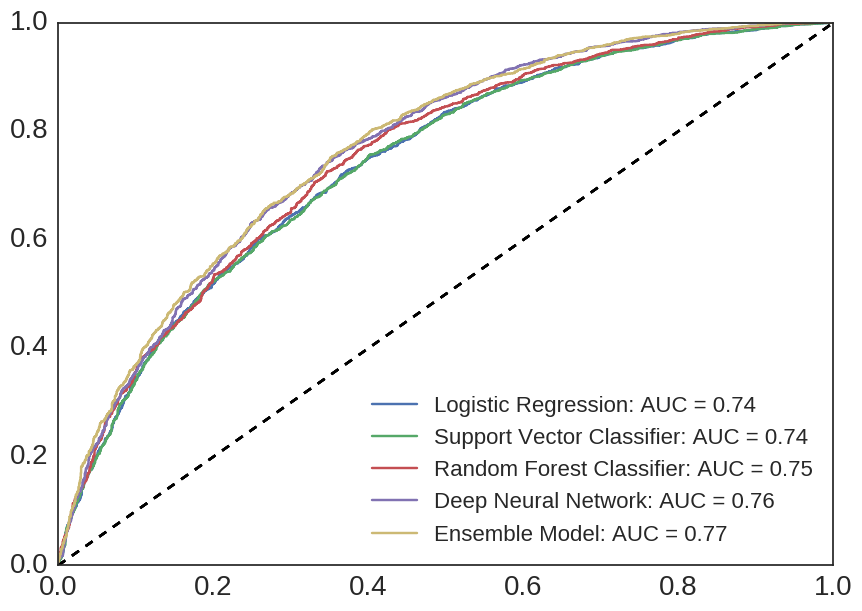

In [136]:
plt.subplots(figsize=(10,7))
for i in range(5):
    plot_roc_curve(roc_vals[0,i,:], roc_probs[0,i,:],clf_names[i],df_avg_scores.loc['AUC',clf_names[i]])

plt.savefig(FIGURE_DIR+'ROC.svg',transparent=True,format='svg')

## Feature Importance
[Back to Top](#Table-of-Contents)

Since there is an element of randomness in the Random Forest algorithm, 20 algorithms were fit to the data to capture the true feature importance. These values stabilize with increasing number of runs (Results not shown)

In [20]:
from sklearn.base import clone

final_imp = pd.DataFrame(index=list_of_features)
for n in tqdm(range(20)):
    tmp_rf = clone(clfs[2])
    tmp_rf.set_params(random_state=n)
    tmp_rf.fit(X_train,y_train) 
    fx_imp = abs(pd.Series(tmp_rf.feature_importances_,index=list_of_features))
    fx_imp /= fx_imp.max() # normalize
    final_imp.loc[:,n] = fx_imp.sort_values(ascending=False)
    

100%|██████████| 20/20 [01:24<00:00,  4.27s/it]


In [21]:
final_imp = final_imp.mean(axis=1).sort_values(ascending=0)

In [22]:
colors = []
for name in final_imp.index:
    if name in aa_features:
        colors.append('deepskyblue')
    elif name in disorder_features:
        colors.append('darkorange')
    elif name in phys_features:
        colors.append('green')
    elif name in rna_features:
        colors.append('brown')
    elif name in ss_features:
        colors.append('mediumorchid')
    else:
        print('Error: Feature not recognized')
        break


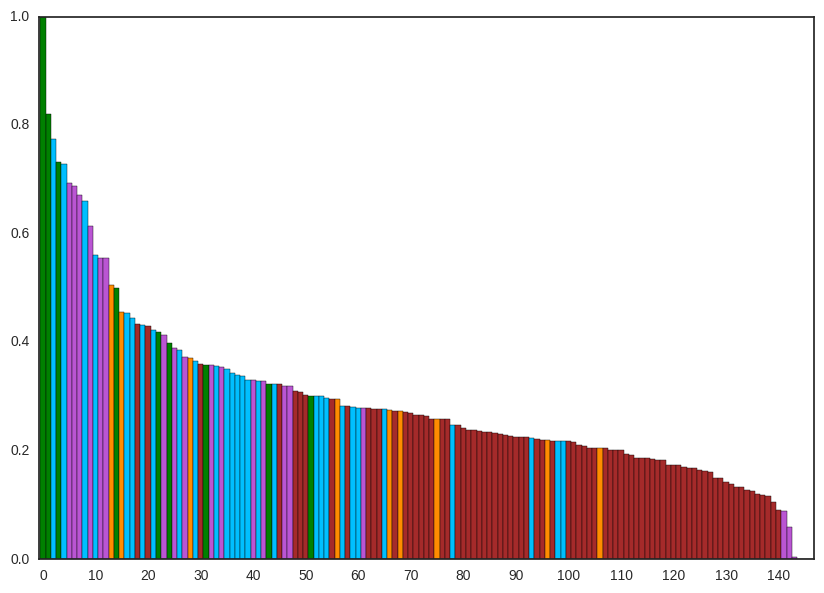

In [23]:
ax = final_imp.plot(kind='bar', color=colors,width=1,figsize=(10,7));
plt.xticks(range(0,len(final_imp),10),range(0,len(final_imp),10),rotation='horizontal');

plt.savefig(FIGURE_DIR+'feature_importance.svg',transparent=True,format='svg')

In [24]:
fx_imp_short = final_imp.sort_values(ascending=0)[:10]
print fx_imp_short.index

Index([u'bio_pI', u'bio_gravy', u'list_comp_L', u'avg_charge', u'frac_polar',
       u'ss8_ext', u'acc_hydrophobic_in', u'ss_ext', u'list_comp_Y',
       u'in_gravy'],
      dtype='object')


In [25]:
new_index = ['Isoelectric Point',
             'Grand Average Value\nof Hydropathy',
             '% Leucine',
             'Average Charge',
             '% Polar Residues',
             'Extended Secondary\nStructure (8-letter)',
             '% Hydrophobic Solvent-\nInaccessible Residues',
             'Extended Secondary\nStructure (3-letter)',
             '% Tyrosine',
             'Average GRAVY of Solvent-\nInaccessible Residues',             
             ] 
fx_imp_short.index = new_index

In [26]:
final_imp.sort_values(ascending=0)[:10]

bio_pI                1.000000
bio_gravy             0.819925
list_comp_L           0.775152
avg_charge            0.732603
frac_polar            0.728989
ss8_ext               0.693007
acc_hydrophobic_in    0.688061
ss_ext                0.672070
list_comp_Y           0.661099
in_gravy              0.614977
dtype: float64

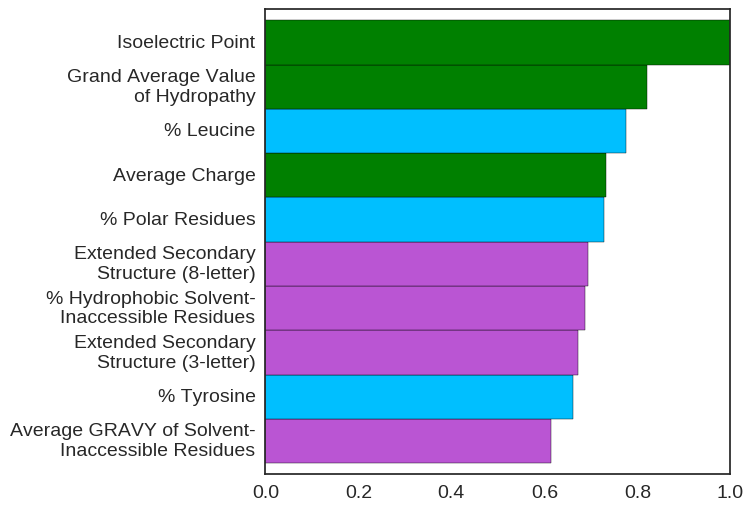

In [27]:
fig = plt.figure(figsize=(6,6))

fx_imp_short.sort_values(ascending=1)[-10:].plot(kind='barh', color=list(reversed(colors[:10])),fontsize=14,width=1)
plt.savefig(FIGURE_DIR+'feature_importance10.svg',transparent=True,format='svg')

In [31]:
pd.DataFrame(final_imp,columns=['Relative Importance'])[:20]

,Relative Importance
bio_pI,1.000000
bio_gravy,0.819925
list_comp_L,0.775152
avg_charge,0.732603
frac_polar,0.728989
ss8_ext,0.693007
acc_hydrophobic_in,0.688061
ss_ext,0.672070
list_comp_Y,0.661099
in_gravy,0.614977


## Feature Heatmaps
[Back to Top](#Table-of-Contents)

In [69]:
bins=50

true_counts = np.zeros((5,5,bins,bins))
false_counts = np.zeros((5,5,bins,bins))


for i in tqdm(range(5)):
    for j in range(5):
        x_feat = DF_prest_features[final_imp.sort_values(ascending=0).index[i]]
        y_feat = DF_prest_features[final_imp.sort_values(ascending=0).index[j]]
        
        x_step = (x_feat.max() - x_feat.min())/bins
        y_step = (y_feat.max() - y_feat.min())/bins
        
        xx = np.arange(x_feat.min(),x_feat.max(),x_step)
        yy = np.arange(y_feat.min(),y_feat.max(),y_step)
        
        for i_xx in range(len(xx)):
            for i_yy in range(len(yy)):
                counts = DF_prest_filtered.expressed[(float(xx[i_xx]) < x_feat) & 
                                                                 (x_feat < float(xx[i_xx]) + x_step) & 
                                                                 (float(yy[i_yy]) < y_feat) & 
                                                                 (y_feat < float(yy[i_yy]) + y_step)].value_counts()
        
                
                try:
                    true_counts[i,j,i_xx,i_yy] = counts.loc[True]
                except:
                    true_counts[i,j,i_xx,i_yy] = 0
                try:
                    false_counts[i,j,i_xx,i_yy] = counts.loc[False]
                except:
                    false_counts[i,j,i_xx,i_yy] = 0
                    
        
        final_counts = true_counts - false_counts
        
final_counts = (true_counts)/(true_counts + false_counts)

low_values_indices = (true_counts + false_counts) < 5 
final_counts[low_values_indices] = np.nan

100%|██████████| 5/5 [01:41<00:00, 20.27s/it]


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


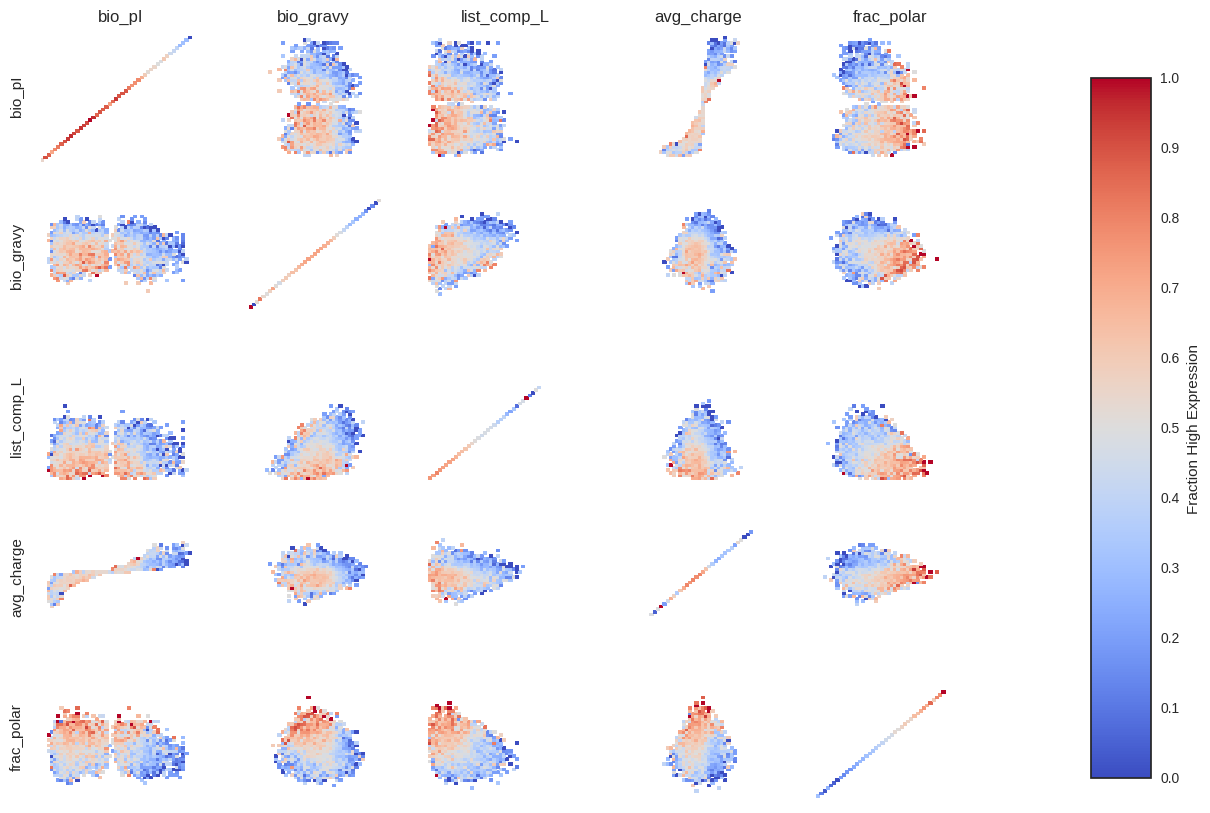

In [72]:
import matplotlib as mpl
sns.set_style('white')
fig,ax = plt.subplots(5,5,figsize=(12,10))

for i in tqdm(range(5)):
    for j in range(5):        
        sns.heatmap(np.flipud(final_counts[i][j]),ax=ax[i][j],cbar=False,cmap='coolwarm')
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])

names = final_imp.sort_values(ascending=0).index[:5]     

for top, col in zip(ax[0], names):
    top.set_title(col)

for side, row in zip(ax[:,0], names):
    side.set_ylabel(row, rotation=90)

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='coolwarm',
                                orientation='vertical')
cb1.set_label('Fraction High Expression')


In [73]:
fig.savefig(FIGURE_DIR+'feature_heatmaps.svg',transparent=True,format='svg',bbox_inches='tight')

In [33]:
DF_prest_features

,list_comp_A,list_comp_R,list_comp_N,list_comp_D,list_comp_C,list_comp_Q,list_comp_E,list_comp_G,list_comp_H,list_comp_I,...,ss8_bridge,ss8_bend,ss8_coil,acc_frac,in_gravy,out_gravy,acc_hydrophilic_in,acc_hydrophilic_out,acc_hydrophobic_in,acc_hydrophobic_out
1,0.111111,0.069444,0.027778,0.000000,0.027778,0.020833,0.118056,0.076389,0.013889,0.020833,...,0.000000,0.013889,0.423611,0.638889,0.378472,-0.747917,0.069444,0.291667,0.263889,0.215278
2,0.066176,0.139706,0.110294,0.044118,0.058824,0.044118,0.000000,0.022059,0.044118,0.051471,...,0.022059,0.117647,0.235294,0.588235,0.360294,-0.994853,0.066176,0.323529,0.323529,0.176471
5,0.029197,0.029197,0.094891,0.080292,0.007299,0.043796,0.036496,0.051095,0.036496,0.058394,...,0.000000,0.021898,0.204380,0.408759,0.595620,-0.551095,0.145985,0.211679,0.408759,0.153285
8,0.074627,0.097015,0.000000,0.007463,0.022388,0.044776,0.171642,0.022388,0.014925,0.052239,...,0.000000,0.007463,0.388060,0.671642,0.573881,-1.178358,0.014925,0.402985,0.246269,0.186567
10,0.035714,0.035714,0.042857,0.035714,0.042857,0.071429,0.085714,0.014286,0.014286,0.035714,...,0.000000,0.028571,0.607143,0.700000,0.487143,-0.905000,0.042857,0.364286,0.242857,0.178571
11,0.044248,0.017699,0.035398,0.070796,0.000000,0.053097,0.079646,0.097345,0.017699,0.097345,...,0.008850,0.044248,0.212389,0.566372,0.917699,-1.092920,0.061947,0.327434,0.345133,0.123894
12,0.105263,0.090226,0.067669,0.037594,0.022556,0.030075,0.067669,0.075188,0.030075,0.037594,...,0.000000,0.000000,0.375940,0.496241,0.581955,-0.908271,0.075188,0.270677,0.383459,0.165414
14,0.040816,0.156463,0.040816,0.047619,0.027211,0.047619,0.034014,0.088435,0.006803,0.034014,...,0.034014,0.136054,0.306122,0.448980,0.382313,-0.879592,0.122449,0.299320,0.340136,0.095238
16,0.066667,0.038095,0.028571,0.038095,0.000000,0.028571,0.285714,0.114286,0.000000,0.019048,...,0.000000,0.019048,0.485714,0.819048,0.557143,-1.844762,0.000000,0.485714,0.161905,0.076190
26,0.090000,0.050000,0.060000,0.050000,0.020000,0.060000,0.090000,0.010000,0.040000,0.030000,...,0.000000,0.070000,0.330000,0.770000,0.236000,-1.463000,0.050000,0.460000,0.170000,0.260000


## Decision Tree
[Back to Top](#Table-of-Contents)

In [74]:
X_dt = DF_prest_filtered[final_imp.sort_values(ascending=0)[:5].index].values
y_dt = DF_prest_filtered.expressed

In [75]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=3,random_state=0).fit(X_dt,1-y_dt)

tree.export_graphviz(dt,out_file=FIGURE_DIR+'tree.dot',
                     feature_names=new_index,
                     class_names=['High Expr','Low Expr'],
                     filled=True,impurity=False,leaves_parallel=True,
                     rounded=True)
subprocess.call(['dot',FIGURE_DIR+'tree.dot','-Tpng','-o',FIGURE_DIR+'tree.png']);